In [ ]:
# def process_data(input_file, output_file):
#     with open(input_file, 'r') as infile, open(output_file, 'w') as outfile:
#         for line in infile:
#             # Split the line into its components
#             parts = line.strip().split(',')
            
#             # Check if we have at least 5 parts (file path + 4 features)
#             if len(parts) >= 5:
#                 # Replace 'None' with 'mixed' in the 4th column (3rd feature)
#                 if parts[3] == 'None':
#                     parts[3] = 'mixed'
                
#                 # Replace 'None' with 'unknown' in other columns
#                 for i in range(1, len(parts)):
#                     if i != 3 and parts[i] == 'None':
#                         parts[i] = 'unknown'
            
#             # Join the parts back into a line and write to output file
#             outfile.write(','.join(parts) + '\n')

# # Usage
# input_file = '/home/zakaria/workspace/ai-photo-enhancer/dataset/categories.txt'
# output_file = 'processed_data.txt'
# process_data(input_file, output_file)

In [ ]:
import os
from pathlib import Path
from torch.utils.data import Dataset
from torchvision.io import read_image
import torchvision.transforms.functional as F
import random
import torch
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np

class FiveKDataset(Dataset):
    def __init__(self, image_size, mode="train", resize=True, 
                 augment_data=True, use_txt_features=False):
        current_dir = os.getcwd()
        dataset_dir = os.path.join(current_dir, "..", "dataset")
        self.IMGS_PATH = os.path.join(dataset_dir, f"FiveK/{mode}")
        self.FEATURES_PATH = os.path.join(dataset_dir, "processed_categories.txt")
        
        self.resize = resize
        self.image_size = image_size
        self.augment_data = augment_data
        self.use_txt_features = use_txt_features
        
        self.img_files = []
        self.features = {}
        self.feature_categories = ["Location", "Time", "Light", "Subject"]
        
        # Load semantic features from processed_categories.txt
        with open(self.FEATURES_PATH, 'r') as f:
            for line in f:
                parts = line.strip().split(',')
                img_name = parts[0]
                img_features = parts[1:]
                self.features[img_name] = img_features
        
        # Load image files
        self.img_files = [f for f in os.listdir(os.path.join(self.IMGS_PATH, 'input'))]
        
        # Prepare MultiLabelBinarizer
        all_features = [self.features[img] for img in self.img_files]
        self.mlb = MultiLabelBinarizer()
        self.mlb.fit(all_features)
        
        # Create encoding dictionaries for categorical approach
        unique_features = {cat: set(feat[i] for feat in all_features) 
                           for i, cat in enumerate(self.feature_categories)}
        self.feature_to_idx = {
            cat: {feat: idx for idx, feat in enumerate(sorted(features))}
            for cat, features in unique_features.items()
        }

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_name = self.img_files[idx]
        source = read_image(os.path.join(self.IMGS_PATH, 'input', img_name))
        target = read_image(os.path.join(self.IMGS_PATH, 'target', img_name))

        if self.resize:
            source = F.resize(source, (self.image_size, self.image_size), 
                              interpolation=F.InterpolationMode.BICUBIC)
            target = F.resize(target, (self.image_size, self.image_size), 
                              interpolation=F.InterpolationMode.BICUBIC)

        if self.augment_data:
            if random.random() > 0.5:
                source = F.hflip(source)
                target = F.hflip(target)
            if random.random() > 0.5:
                source = F.vflip(source)
                target = F.vflip(target)

        if not self.use_txt_features:
            return source, target

        elif self.use_txt_features == "one_hot":
            # One-hot encode the features using MultiLabelBinarizer
            one_hot_features = self.mlb.transform([self.features[img_name]])[0]
            one_hot_features = torch.tensor(one_hot_features, dtype=torch.float32)
            return source, one_hot_features, target

        elif self.use_txt_features == "categorical":
            # Return categorical indices
            cat_features = [self.feature_to_idx[cat][feat] 
                            for cat, feat in 
                            zip(self.feature_categories, self.features[img_name])]
            cat_features = torch.tensor(cat_features, dtype=torch.long)
            return source, cat_features, target

        else:
            raise ValueError("Invalid value for use_txt_features. Must be False, 'one_hot' or 'categorical'.")

    def collate_fn(self, batch):
        sources, features, targets = zip(*batch)
        sources = torch.stack(sources)
        targets = torch.stack(targets)
        
        if self.use_txt_features in ["one_hot", "categorical"]:
            features = torch.stack(features)
        else:
            features = None

        return sources, features, targets

In [ ]:
from torch.utils.data import DataLoader

a =FiveKDataset(244,use_txt_features='one_hot')
d = DataLoader(a, batch_size=32 , shuffle = True)

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(a[0][0].permute(1,2,0))

In [ ]:
a.feature_to_idx

In [ ]:
a.features['a0001-jmac_DSC1459.jpg']

In [ ]:
a.img_files

In [ ]:
import os
from pathlib import Path
from torch.utils.data import Dataset
from torchvision.io import read_image
import torchvision.transforms.functional as F
import random
import torch
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
from transformers import BertTokenizer, BertModel

class FiveKDataset(Dataset):
    def __init__(self, image_size, mode="train", resize=True, augment_data=True, use_txt_features=False):
        # ... [previous initialization code remains the same] ...

        current_dir = os.getcwd()
        dataset_dir = os.path.join(current_dir, "..", "dataset")
        self.IMGS_PATH = os.path.join(dataset_dir, f"FiveK/{mode}")
        self.FEATURES_PATH = os.path.join(dataset_dir, "processed_categories.txt")
        
        self.resize = resize
        self.image_size = image_size
        self.augment_data = augment_data
        self.use_txt_features = use_txt_features
        
        self.img_files = []
        self.features = {}
        self.feature_categories = ["Location", "Time", "Light", "Subject"]
        
        # Load semantic features from processed_categories.txt
        with open(self.FEATURES_PATH, 'r') as f:
            for line in f:
                parts = line.strip().split(',')
                img_name = parts[0]
                img_features = parts[1:]
                self.features[img_name] = img_features
        
        # Load image files
        self.img_files = [f for f in os.listdir(os.path.join(self.IMGS_PATH, 'input'))]
        
        # Prepare MultiLabelBinarizer
        all_features = [self.features[img] for img in self.img_files]
        self.mlb = MultiLabelBinarizer()
        self.mlb.fit(all_features)
        
        # Create encoding dictionaries for categorical approach
        unique_features = {cat: set(feat[i] for feat in all_features) 
                           for i, cat in enumerate(self.feature_categories)}
        self.feature_to_idx = {
            cat: {feat: idx for idx, feat in enumerate(sorted(features))}
            for cat, features in unique_features.items()
        }
        
        if self.use_txt_features == "embedded":
            self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
            self.bert_model = BertModel.from_pretrained('bert-base-uncased')
            self.bert_model.eval()  # Set to evaluation mode

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_name = self.img_files[idx]
        source = read_image(os.path.join(self.IMGS_PATH, 'input', img_name))
        target = read_image(os.path.join(self.IMGS_PATH, 'target', img_name))

        if self.resize:
            source = F.resize(source, (self.image_size, self.image_size), interpolation=F.InterpolationMode.BICUBIC)
            target = F.resize(target, (self.image_size, self.image_size), interpolation=F.InterpolationMode.BICUBIC)

        if self.augment_data:
            if random.random() > 0.5:
                source = F.hflip(source)
                target = F.hflip(target)
            if random.random() > 0.5:
                source = F.vflip(source)
                target = F.vflip(target)

        if not self.use_txt_features:
            return source, target

        elif self.use_txt_features == "one_hot":
            # One-hot encode the features using MultiLabelBinarizer
            one_hot_features = self.mlb.transform([self.features[img_name]])[0]
            one_hot_features = torch.tensor(one_hot_features, dtype=torch.float32)
            return source, one_hot_features, target

        elif self.use_txt_features == "categorical":
            # Return categorical indices
            cat_features = [self.feature_to_idx[cat][feat] for cat, feat in zip(self.feature_categories, self.features[img_name])]
            cat_features = torch.tensor(cat_features, dtype=torch.long)
            return source, cat_features, target

        elif self.use_txt_features == "embedded":
            # Combine features into a single string
            feature_text = " ".join(self.features[img_name])
            
            # Tokenize and get BERT embeddings
            inputs = self.tokenizer(feature_text, return_tensors="pt", padding=True, truncation=True, max_length=512)
            with torch.no_grad():
                outputs = self.bert_model(**inputs)
            
            # Use the [CLS] token embedding as the feature representation
            embedded_features = outputs.last_hidden_state[:, 0, :]  # Shape: (1, 768)
            embedded_features = embedded_features.squeeze(0)  # Shape: (768,)
            
            return source, embedded_features, target

        else:
            raise ValueError("Invalid value for use_txt_features. Must be False, 'one_hot', 'categorical', or 'embedded'.")

    def collate_fn(self, batch):
        sources, features, targets = zip(*batch)
        sources = torch.stack(sources)
        targets = torch.stack(targets)
        
        if self.use_txt_features in ["one_hot", "categorical", "embedded"]:
            features = torch.stack(features)
        else:
            features = None

        return sources, features, targets

In [ ]:
a = FiveKDataset(244,use_txt_features='embedded')

In [ ]:
a[0][1].shape

In [3]:
import os
from pathlib import Path
from torch.utils.data import Dataset
from torchvision.io import read_image
import torchvision.transforms.functional as F
import random
import torch
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
from transformers import BertTokenizer, BertModel
from tqdm import tqdm

class FiveKDataset(Dataset):
    def __init__(self, image_size, mode="train", resize=True, 
                 augment_data=False, use_txt_features=False,device='cuda'):
        current_dir = os.getcwd()
        dataset_dir = os.path.join(current_dir, "..", "dataset")
        self.IMGS_PATH = os.path.join(dataset_dir, f"FiveK/{mode}")
        self.FEATURES_PATH = os.path.join(dataset_dir, "processed_categories.txt")
        self.device = device #used for precomputing embedded features
        self.resize = resize
        self.image_size = image_size
        self.augment_data = augment_data
        self.use_txt_features = use_txt_features
        
        self.img_files = []
        self.features = {}
        self.feature_categories = ["Location", "Time", "Light", "Subject"]
        
        # Load semantic features from processed_categories.txt
        with open(self.FEATURES_PATH, 'r') as f:
            for line in f:
                parts = line.strip().split(',')
                img_name = parts[0]
                img_features = parts[1:]
                self.features[img_name] = img_features
        
        # Load image files
        self.img_files = [f for f in os.listdir(os.path.join(self.IMGS_PATH, 'input'))]
        
        # Prepare MultiLabelBinarizer
        all_features = [self.features[img] for img in self.img_files]
        self.mlb = MultiLabelBinarizer()
        self.mlb.fit(all_features)
        
        # Create encoding dictionaries for categorical approach
        unique_features = {cat: set(feat[i] for feat in all_features) 
                           for i, cat in enumerate(self.feature_categories)}
        self.feature_to_idx = {
            cat: {feat: idx for idx, feat in enumerate(sorted(features))}
            for cat, features in unique_features.items()
        }
        
        self.precomputed_features = {}
        if self.use_txt_features == "embedded":
            self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
            self.bert_model = BertModel.from_pretrained('bert-base-uncased').to(self.device)
            self.bert_model.eval()  # Set to evaluation mode
            self.precompute_embeddings()

    def precompute_embeddings(self):
        print("Precomputing embeddings...")
        for img_name in tqdm(self.img_files):
            feature_text = " ".join(self.features[img_name])
            inputs = self.tokenizer(feature_text, return_tensors="pt", padding=True, truncation=True, max_length=512)
            with torch.no_grad():
                outputs = self.bert_model(**inputs.to(self.device))
            embedded_features = outputs.last_hidden_state[:, 0, :].squeeze(0)  # Shape: (768,)
            self.precomputed_features[img_name] = embedded_features.to(self.device)
        del self.bert_model
        del self.tokenizer
        print("Embeddings precomputed and stored.")

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_name = self.img_files[idx]
        source = read_image(os.path.join(self.IMGS_PATH, 'input', img_name))
        target = read_image(os.path.join(self.IMGS_PATH, 'target', img_name))

        if self.resize:
            source = F.resize(source, (self.image_size, self.image_size), interpolation=F.InterpolationMode.BICUBIC)
            target = F.resize(target, (self.image_size, self.image_size), interpolation=F.InterpolationMode.BICUBIC)

        if self.augment_data:
            if random.random() > 0.5:
                source = F.hflip(source)
                target = F.hflip(target)
            if random.random() > 0.5:
                source = F.vflip(source)
                target = F.vflip(target)

        if not self.use_txt_features:
            return source, target

        elif self.use_txt_features == "one_hot":
            one_hot_features = self.mlb.transform([self.features[img_name]])[0]
            one_hot_features = torch.tensor(one_hot_features, dtype=torch.float32)
            return source, one_hot_features, target

        elif self.use_txt_features == "categorical":
            cat_features = [self.feature_to_idx[cat][feat] for cat, feat in zip(self.feature_categories, self.features[img_name])]
            cat_features = torch.tensor(cat_features, dtype=torch.long)
            return source, cat_features, target

        elif self.use_txt_features == "embedded":
            return source, self.precomputed_features[img_name], target

        else:
            raise ValueError("Invalid value for use_txt_features. Must be False, 'one_hot', 'categorical', or 'embedded'.")

    def collate_fn(self, batch):
        sources, features, targets = zip(*batch)
        sources = torch.stack(sources)
        targets = torch.stack(targets)
        
        if self.use_txt_features in ["one_hot", "categorical", "embedded"]:
            features = torch.stack(features)
        else:
            features = None

        return sources, features, targets

In [4]:
dataset = FiveKDataset(image_size=64, mode="train", use_txt_features="embedded")

Precomputing embeddings...


 51%|█████     | 2299/4500 [00:20<00:19, 112.35it/s]


KeyboardInterrupt: 

In [2]:
import os
from pathlib import Path
from torch.utils.data import Dataset
from torchvision.io import read_image
import torchvision.transforms.functional as F
import random
import torch
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
from transformers import BertTokenizer, BertModel, CLIPProcessor, CLIPModel
from tqdm import tqdm

class FiveKDataset(Dataset):
    def __init__(self, image_size, mode="train", resize=True, 
                 augment_data=False, use_txt_features=False,device='cuda'):
        current_dir = os.getcwd()
        dataset_dir = os.path.join(current_dir, "..", "dataset")
        self.IMGS_PATH = os.path.join(dataset_dir, f"FiveK/{mode}")
        self.FEATURES_PATH = os.path.join(dataset_dir, "processed_categories.txt")
        
        self.resize = resize
        self.image_size = image_size
        self.augment_data = augment_data
        self.use_txt_features = use_txt_features
        self.device = device
        self.img_files = []
        self.features = {}
        self.feature_categories = ["Location", "Time", "Light", "Subject"]
        
        # Load semantic features from processed_categories.txt
        with open(self.FEATURES_PATH, 'r') as f:
            for line in f:
                parts = line.strip().split(',')
                img_name = parts[0]
                img_features = parts[1:]
                self.features[img_name] = img_features
        
        # Load image files
        self.img_files = [f for f in os.listdir(os.path.join(self.IMGS_PATH, 'input'))]
        
        # Prepare MultiLabelBinarizer
        all_features = [self.features[img] for img in self.img_files]
        self.mlb = MultiLabelBinarizer()
        self.mlb.fit(all_features)
        
        # Create encoding dictionaries for categorical approach
        unique_features = {cat: set(feat[i] for feat in all_features) 
                           for i, cat in enumerate(self.feature_categories)}
        self.feature_to_idx = {
            cat: {feat: idx for idx, feat in enumerate(sorted(features))}
            for cat, features in unique_features.items()
        }
        
        self.precomputed_bert_features = {}
        self.precomputed_clip_features = {}
        
        if self.use_txt_features == "embedded":
            self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
            self.bert_model = BertModel.from_pretrained('bert-base-uncased')
            self.bert_model.eval()
            self.bert_model.to(self.device)
            self.clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
            self.clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
            self.clip_model.eval()
            self.clip_model.to(self.device)
            self.precompute_features()

    def precompute_features(self):
        print("Precomputing BERT and CLIP features...")
        for img_name in tqdm(self.img_files):
            # Precompute BERT features
            feature_text = " ".join(self.features[img_name])
            inputs = self.tokenizer(feature_text, return_tensors="pt", padding=True, truncation=True, max_length=512)
            with torch.no_grad():
                
                outputs = self.bert_model(**inputs.to(self.device))
            bert_features = outputs.last_hidden_state[:, 0, :].squeeze(0)  # Shape: (768,)
            self.precomputed_bert_features[img_name] = bert_features.cpu()

            # Precompute CLIP features
            image_path = os.path.join(self.IMGS_PATH, 'input', img_name)
            image = read_image(image_path)
            if self.resize:
                image = F.resize(image, (self.image_size, self.image_size), interpolation=F.InterpolationMode.BICUBIC)
            clip_inputs = self.clip_processor(images=image, return_tensors="pt")
            with torch.no_grad():
                
                clip_features = self.clip_model.get_image_features(**clip_inputs.to(self.device))

            self.precomputed_clip_features[img_name] = clip_features.squeeze(0).cpu()  # Shape: (512,)
        del self.bert_model
        del self.tokenizer    
        del self.clip_model
        del self.clip_processor  
        print("BERT and CLIP features precomputed and stored.")

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_name = self.img_files[idx]
        source = read_image(os.path.join(self.IMGS_PATH, 'input', img_name))
        target = read_image(os.path.join(self.IMGS_PATH, 'target', img_name))

        if self.resize:
            source = F.resize(source, (self.image_size, self.image_size), interpolation=F.InterpolationMode.BICUBIC)
            target = F.resize(target, (self.image_size, self.image_size), interpolation=F.InterpolationMode.BICUBIC)

        if self.augment_data:
            if random.random() > 0.5:
                source = F.hflip(source)
                target = F.hflip(target)
            if random.random() > 0.5:
                source = F.vflip(source)
                target = F.vflip(target)

        if not self.use_txt_features:
            return source, target

        elif self.use_txt_features == "one_hot":
            one_hot_features = self.mlb.transform([self.features[img_name]])[0]
            one_hot_features = torch.tensor(one_hot_features, dtype=torch.float32)
            return source, one_hot_features, target

        elif self.use_txt_features == "categorical":
            cat_features = [self.feature_to_idx[cat][feat] for cat, feat in zip(self.feature_categories, self.features[img_name])]
            cat_features = torch.tensor(cat_features, dtype=torch.long)
            return source, cat_features, target

        elif self.use_txt_features == "embedded":
            bert_features = self.precomputed_bert_features[img_name]
            clip_features = self.precomputed_clip_features[img_name]
            return source, bert_features, clip_features, target

        else:
            raise ValueError("Invalid value for use_txt_features. Must be False, 'one_hot', 'categorical', or 'embedded'.")

    def collate_fn(self, batch):
        if self.use_txt_features == "embedded":
            sources, bert_features, clip_features, targets = zip(*batch)
            sources = torch.stack(sources)
            bert_features = torch.stack(bert_features)
            clip_features = torch.stack(clip_features)
            targets = torch.stack(targets)
            return sources, bert_features, clip_features, targets
        else:
            sources, features, targets = zip(*batch)
            sources = torch.stack(sources)
            targets = torch.stack(targets)
            if self.use_txt_features in ["one_hot", "categorical"]:
                features = torch.stack(features)
            else:
                features = None
            return sources, features, targets

In [3]:
dataset = FiveKDataset(image_size=64, mode="train", use_txt_features="embedded")

Precomputing BERT and CLIP features...


100%|██████████| 4500/4500 [04:34<00:00, 16.41it/s]

BERT and CLIP features precomputed and stored.


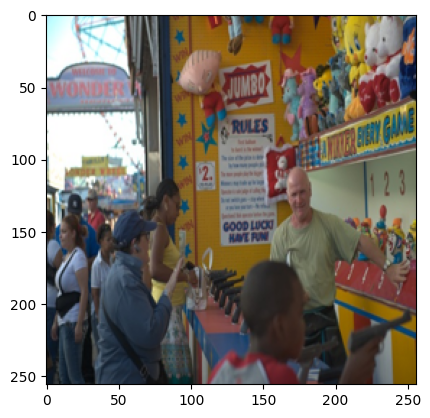

In [7]:
import matplotlib.pyplot as plt

plt.imshow(dataset[0][0].permute(1, 2, 0))

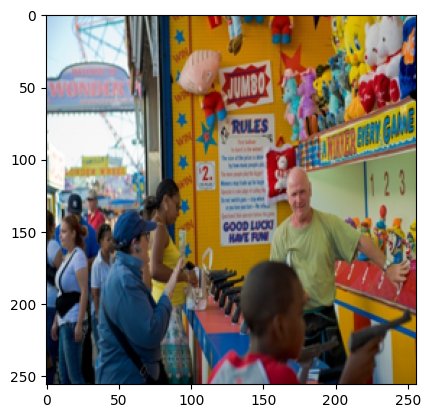

In [9]:
plt.imshow(dataset[0][-1].permute(1, 2, 0))

In [20]:
import torch
import torch.nn as nn

class CrossModalAttention(nn.Module):
    def __init__(self, bert_dim=768, clip_dim=512, resnet_dim=512, common_dim=512):
        super().__init__()
        self.bert_projection = nn.Linear(bert_dim, common_dim)
        self.clip_projection = nn.Linear(clip_dim, common_dim)
        self.resnet_projection = nn.Linear(resnet_dim, common_dim)
        
        self.attention = nn.MultiheadAttention(embed_dim=common_dim, num_heads=8)
        
    def forward(self, bert_features, clip_features, resnet_features):
        # Project all features to a common dimension
        q = self.bert_projection(bert_features)
        k = self.clip_projection(clip_features)
        v = self.resnet_projection(resnet_features)
        
        # Reshape tensors to (seq_len, batch_size, common_dim)
        q = q.unsqueeze(0)  # (1, batch_size, common_dim)
        k = k.unsqueeze(0)  # (1, batch_size, common_dim)
        v = v.unsqueeze(0)  # (1, batch_size, common_dim)
        
        # Compute attention
        attn_output, _ = self.attention(query=q, key=k, value=v)
        
        return attn_output.squeeze(0)  # (batch_size, common_dim)

# Test the module
att = CrossModalAttention()

# Create dummy data
batch_size = 32
res_f = torch.rand(batch_size, 512)
bert_f = torch.rand(batch_size, 768)
clip_f = torch.rand(batch_size, 512)

# Forward pass
out = att(bert_f, clip_f, res_f)
print(out.shape)  # Should print torch.Size([32, 512])

torch.Size([32, 512])


In [23]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp
get_n_params(att)

1969664

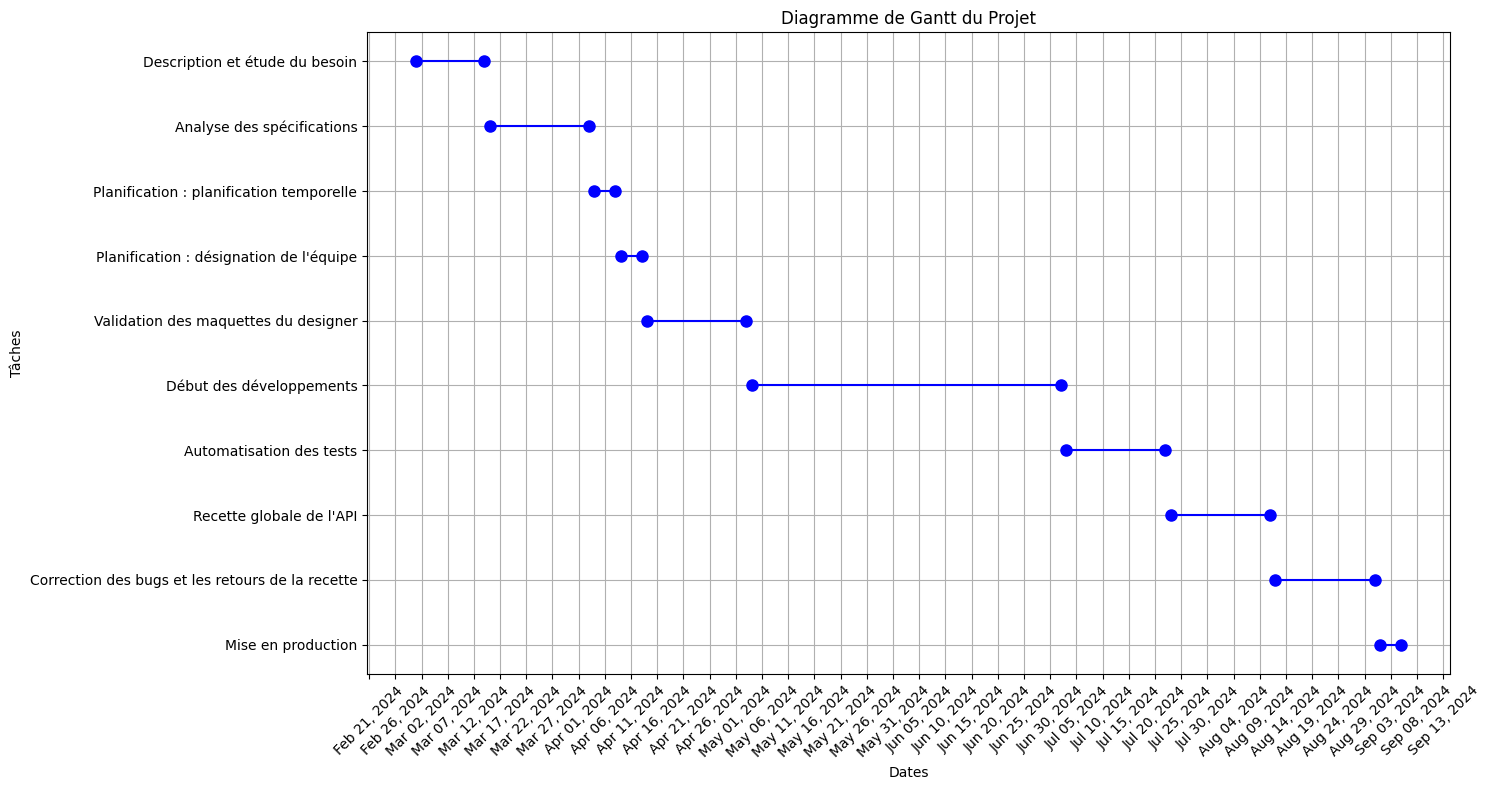

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Définir les tâches avec les dates de début et de fin
tasks = [
    {"Task": "Description et étude du besoin", "Start": "2024-03-01", "End": "2024-03-14"},
    {"Task": "Analyse des spécifications", "Start": "2024-03-15", "End": "2024-04-03"},
    {"Task": "Planification : planification temporelle", "Start": "2024-04-04", "End": "2024-04-08"},
    {"Task": "Planification : désignation de l'équipe", "Start": "2024-04-09", "End": "2024-04-13"},
    {"Task": "Validation des maquettes du designer", "Start": "2024-04-14", "End": "2024-05-03"},
    {"Task": "Début des développements", "Start": "2024-05-04", "End": "2024-07-02"},
    {"Task": "Automatisation des tests", "Start": "2024-07-03", "End": "2024-07-22"},
    {"Task": "Recette globale de l'API", "Start": "2024-07-23", "End": "2024-08-11"},
    {"Task": "Correction des bugs et les retours de la recette", "Start": "2024-08-12", "End": "2024-08-31"},
    {"Task": "Mise en production", "Start": "2024-09-01", "End": "2024-09-05"}
]

# Convertir les données des tâches en DataFrame
df = pd.DataFrame(tasks)

# Convertir les chaînes de dates en objets datetime
df['Start'] = pd.to_datetime(df['Start'])
df['End'] = pd.to_datetime(df['End'])

# Inverser l'ordre des tâches
df_reversed = df.iloc[::-1].reset_index(drop=True)

# Tracer le diagramme de Gantt avec les tâches inversées et inclure les jours
fig, ax = plt.subplots(figsize=(15, 8))

# Tracer chaque tâche
for i, task in df_reversed.iterrows():
    ax.plot([task['Start'], task['End']], [i, i], color='blue', marker='o', markersize=8)

# Définir les étiquettes de l'axe y aux noms des tâches
ax.set_yticks(range(len(df_reversed)))
ax.set_yticklabels(df_reversed['Task'])

# Formater l'axe x pour afficher les dates et les jours
ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d, %Y'))

# Définir les labels et le titre
plt.xlabel('Dates')
plt.ylabel('Tâches')
plt.title('Diagramme de Gantt du Projet')

# Faire pivoter les étiquettes des dates
plt.xticks(rotation=45)

plt.tight_layout()
plt.grid(True)
plt.show()

# Sauvegarder le diagramme de Gantt avec les jours inclus
fig.savefig("gantt_chart_project_with_days.svg", format='svg')

In [12]:
torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

device(type='cuda', index=0)